In [17]:
!pip install tf-nightly --upgrade
!pip install jax --upgrade
!pip install jaxlib --upgrade

In [18]:
import jax
import tensorflow as tf
import torch
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import tensorflow.keras as keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from operator import itemgetter
def print_public_attributes(obj):
    print(list([att for att in dir(obj) 
         if '__' not in att and not att.startswith('_')]))

In [20]:
from PIL import Image
import requests
from io import BytesIO

def Image_from_url(url):
    response = requests.get(url,stream=True)
    img = Image.open(response.raw)
    return img

c = Image_from_url('https://github.com/GlebSBrykin/SANET/raw/master/input/chicago.jpg')
s = Image_from_url('https://raw.githubusercontent.com/tornikeo/stylize-website-js/main/sample_images/starry.jpg')

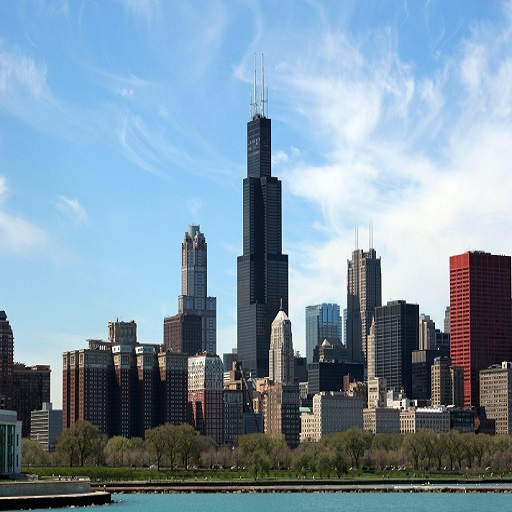

In [21]:
c

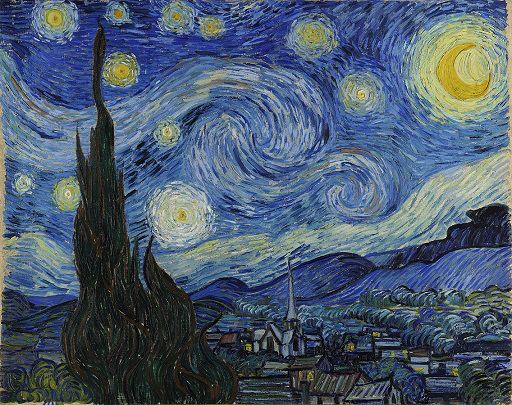

In [22]:
s

In [23]:

def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def mean_variance_norm(feat):
    size = feat.size()
    mean, std = calc_mean_std(feat)
    normalized_feat = (feat - mean.expand(size)) / std.expand(size)
    return normalized_feat

def _calc_feat_flatten_mean_std(feat):
    # takes 3D feat (C, H, W), return mean and std of array within channels
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std

import torch.nn as nn

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)


class SANet(nn.Module):
    def __init__(self, in_planes):
        super(SANet, self).__init__()
        self.f = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.g = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.h = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.sm = nn.Softmax(dim = -1)
        self.out_conv = nn.Conv2d(in_planes, in_planes, (1, 1))
    def forward(self, content, style):
        F = self.f(mean_variance_norm(content))
        G = self.g(mean_variance_norm(style))
        H = self.h(style)
        b, c, h, w = F.size()
        F = F.view(b, -1, w * h).permute(0, 2, 1)
        b, c, h, w = G.size()
        G = G.view(b, -1, w * h)
        S = torch.bmm(F, G)
        S = self.sm(S)
        b, c, h, w = H.size()
        H = H.view(b, -1, w * h)
        O = torch.bmm(H, S.permute(0, 2, 1))
        b, c, h, w = content.size()
        O = O.view(b, c, h, w)
        O = self.out_conv(O)
        O += content
        return O

class Transform(nn.Module):
    def __init__(self, in_planes):
        super(Transform, self).__init__()
        self.sanet4_1 = SANet(in_planes = in_planes)
        self.sanet5_1 = SANet(in_planes = in_planes)
        self.upsample5_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.merge_conv_pad = nn.ReflectionPad2d((1, 1, 1, 1))
        self.merge_conv = nn.Conv2d(in_planes, in_planes, (3, 3))
    def forward(self, content4_1, style4_1, content5_1, style5_1):
        return self.merge_conv(self.merge_conv_pad(self.sanet4_1(content4_1, style4_1) + self.upsample5_1(self.sanet5_1(content5_1, style5_1))))

class Net(nn.Module):
    def __init__(self, encoder, decoder, start_iter):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.enc_5 = nn.Sequential(*enc_layers[31:44])  # relu4_1 -> relu5_1
        #transform
        self.transform = Transform(in_planes = 512)
        self.decoder = decoder
        if(start_iter > 0):
            self.transform.load_state_dict(torch.load('transformer_iter_' + str(start_iter) + '.pth'))
            self.decoder.load_state_dict(torch.load('decoder_iter_' + str(start_iter) + '.pth'))
        self.mse_loss = nn.MSELoss()
        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4', 'enc_5']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1, relu5_1 from input image
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(5):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    def calc_content_loss(self, input, target, norm = False):
        if(norm == False):
          return self.mse_loss(input, target)
        else:
          return self.mse_loss(mean_variance_norm(input), mean_variance_norm(target))

    def calc_style_loss(self, input, target):
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)
    
    def forward(self, content, style):
        style_feats = self.encode_with_intermediate(style)
        content_feats = self.encode_with_intermediate(content)
        stylized = self.transform(content_feats[3], style_feats[3], content_feats[4], style_feats[4])
        g_t = self.decoder(stylized)
        g_t_feats = self.encode_with_intermediate(g_t)
        loss_c = self.calc_content_loss(g_t_feats[3], content_feats[3], norm = True) + self.calc_content_loss(g_t_feats[4], content_feats[4], norm = True)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 5):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        """IDENTITY LOSSES"""
        Icc = self.decoder(self.transform(content_feats[3], content_feats[3], content_feats[4], content_feats[4]))
        Iss = self.decoder(self.transform(style_feats[3], style_feats[3], style_feats[4], style_feats[4]))
        l_identity1 = self.calc_content_loss(Icc, content) + self.calc_content_loss(Iss, style)
        Fcc = self.encode_with_intermediate(Icc)
        Fss = self.encode_with_intermediate(Iss)
        l_identity2 = self.calc_content_loss(Fcc[0], content_feats[0]) + self.calc_content_loss(Fss[0], style_feats[0])
        for i in range(1, 5):
            l_identity2 += self.calc_content_loss(Fcc[i], content_feats[i]) + self.calc_content_loss(Fss[i], style_feats[i])
        return loss_c, loss_s, l_identity1, l_identity2


In [25]:
vgg.load_state_dict(torch.load('../input/sanetweights/vgg_normalised.pth'))

<All keys matched successfully>

In [31]:
vgg_weights = torch.load('../input/sanetweights/vgg_normalised.pth')

for k,v in vgg_weights.items():
    print(k,v.shape)

0.weight torch.Size([3, 3, 1, 1])
0.bias torch.Size([3])
2.weight torch.Size([64, 3, 3, 3])
2.bias torch.Size([64])
5.weight torch.Size([64, 64, 3, 3])
5.bias torch.Size([64])
9.weight torch.Size([128, 64, 3, 3])
9.bias torch.Size([128])
12.weight torch.Size([128, 128, 3, 3])
12.bias torch.Size([128])
16.weight torch.Size([256, 128, 3, 3])
16.bias torch.Size([256])
19.weight torch.Size([256, 256, 3, 3])
19.bias torch.Size([256])
22.weight torch.Size([256, 256, 3, 3])
22.bias torch.Size([256])
25.weight torch.Size([256, 256, 3, 3])
25.bias torch.Size([256])
29.weight torch.Size([512, 256, 3, 3])
29.bias torch.Size([512])
32.weight torch.Size([512, 512, 3, 3])
32.bias torch.Size([512])
35.weight torch.Size([512, 512, 3, 3])
35.bias torch.Size([512])
38.weight torch.Size([512, 512, 3, 3])
38.bias torch.Size([512])
42.weight torch.Size([512, 512, 3, 3])
42.bias torch.Size([512])
45.weight torch.Size([512, 512, 3, 3])
45.bias torch.Size([512])
48.weight torch.Size([512, 512, 3, 3])
48.bias 

In [103]:
nn.Conv2d(1,2,(3,4)).get_parameter('weight').shape

torch.Size([2, 1, 3, 4])

In [114]:
import jax.numpy as jnp
from jax import lax


def conv_filter_to_tf(conv_layer):
    filters = tf.constant(conv_layer.get_parameter('weight')
                              .permute(2,3,1,0)
                          .detach().numpy(),
                       tf.float16)
    
    bias = tf.constant(conv_layer.get_parameter('bias')
                          .detach().numpy(),
                       tf.float16)
    return filters, bias 

def stylize(content, style):
    print(content.shape, style.shape)
    def enc(x):
        x = x[None,...] / 255.
        for layer in vgg:
            layer_id = str(layer).lower()
            print(layer_id)
            if 'conv' in layer_id:
                filters, bias = conv_filter_to_tf(layer)
                print('in',x.shape)
                print('filters', filters.shape)
                x = tf.nn.conv2d(x,filters,
                                 strides=1,
                                 padding='VALID') + bias
                print('out', x.shape)
            elif 'relu' in layer_id:
                x = tf.nn.relu(x)
            elif 'pool' in layer_id:
                x = tf.nn.max_pool2d(x,2,2,'VALID')
            elif 'pad' in layer_id:
                x = tf.pad(x,((0,0),(1,1),(1,1),(0,0)), mode='REFLECT')
        return x
    c_enc = enc(content)
    return c_enc

content = np.array(c)
style = np.array(s)
style = tf.image.resize(style, content.shape[:2])
result = stylize(content,style)
expected = vgg(T.ToTensor()(c)[None,...])

# in_channels, out_channels, kernel_size

# tf.nn.conv2d(x,,data_format='NCHW')
# [filter_height, filter_width, in_channels, out_channels]

(512, 512, 3) (512, 512, 3)
conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
in (1, 512, 512, 3)
filters (1, 1, 3, 3)
out (1, 512, 512, 3)
reflectionpad2d((1, 1, 1, 1))
conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
in (1, 514, 514, 3)
filters (3, 3, 3, 64)
out (1, 512, 512, 64)
relu()
reflectionpad2d((1, 1, 1, 1))
conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
in (1, 514, 514, 64)
filters (3, 3, 64, 64)
out (1, 512, 512, 64)
relu()
maxpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=true)
reflectionpad2d((1, 1, 1, 1))
conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
in (1, 258, 258, 64)
filters (3, 3, 64, 128)
out (1, 256, 256, 128)
relu()
reflectionpad2d((1, 1, 1, 1))
conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
in (1, 258, 258, 128)
filters (3, 3, 128, 128)
out (1, 256, 256, 128)
relu()
maxpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=true)
reflectionpad2d((1, 1, 1, 1))
conv2d(128, 256, kernel_size=(3, 3),

In [131]:
(result.numpy() - expected.permute(0,2,3,1).detach().numpy())

-0.26509094